# 대회 개요

우리는 카메라로 비춰진 사람 얼굴 이미지 만으로 이 사람이 마스크를 쓰고 있는지, 쓰지 않았는지, 정확히 쓴 것이 맞는지 자동으로 가려낼 수 있는 시스템이 필요합니다. <br>
이 시스템이 공공장소 입구에 갖춰져 있다면 적은 인적자원으로도 충분히 검사가 가능할 것입니다.

### EDA 탐색적 데이터 분석 (참고)
https://eda-ai-lab.tistory.com/13

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
%matplotlib inline

In [2]:
train_data_dir_path = os.getcwd() + '/input/data/train/'
train_csv_path = train_data_dir_path + 'train.csv'
train_image_path = train_data_dir_path + 'images/'

In [3]:
train_df = pd.read_csv(train_csv_path)

In [4]:
train_df

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


In [5]:
image_paths = train_image_path + train_df['path']
image_paths[:4]

0    /opt/ml/input/data/train/images/000001_female_...
1    /opt/ml/input/data/train/images/000002_female_...
2    /opt/ml/input/data/train/images/000004_male_As...
3    /opt/ml/input/data/train/images/000005_female_...
Name: path, dtype: object

## 랜덤한 N명 이미지 확인하기

0 /opt/ml/input/data/train/images/003106_female_Asian_20
1 /opt/ml/input/data/train/images/000637_female_Asian_50
2 /opt/ml/input/data/train/images/001481_male_Asian_55
3 /opt/ml/input/data/train/images/005528_female_Asian_40
4 /opt/ml/input/data/train/images/004284_male_Asian_60


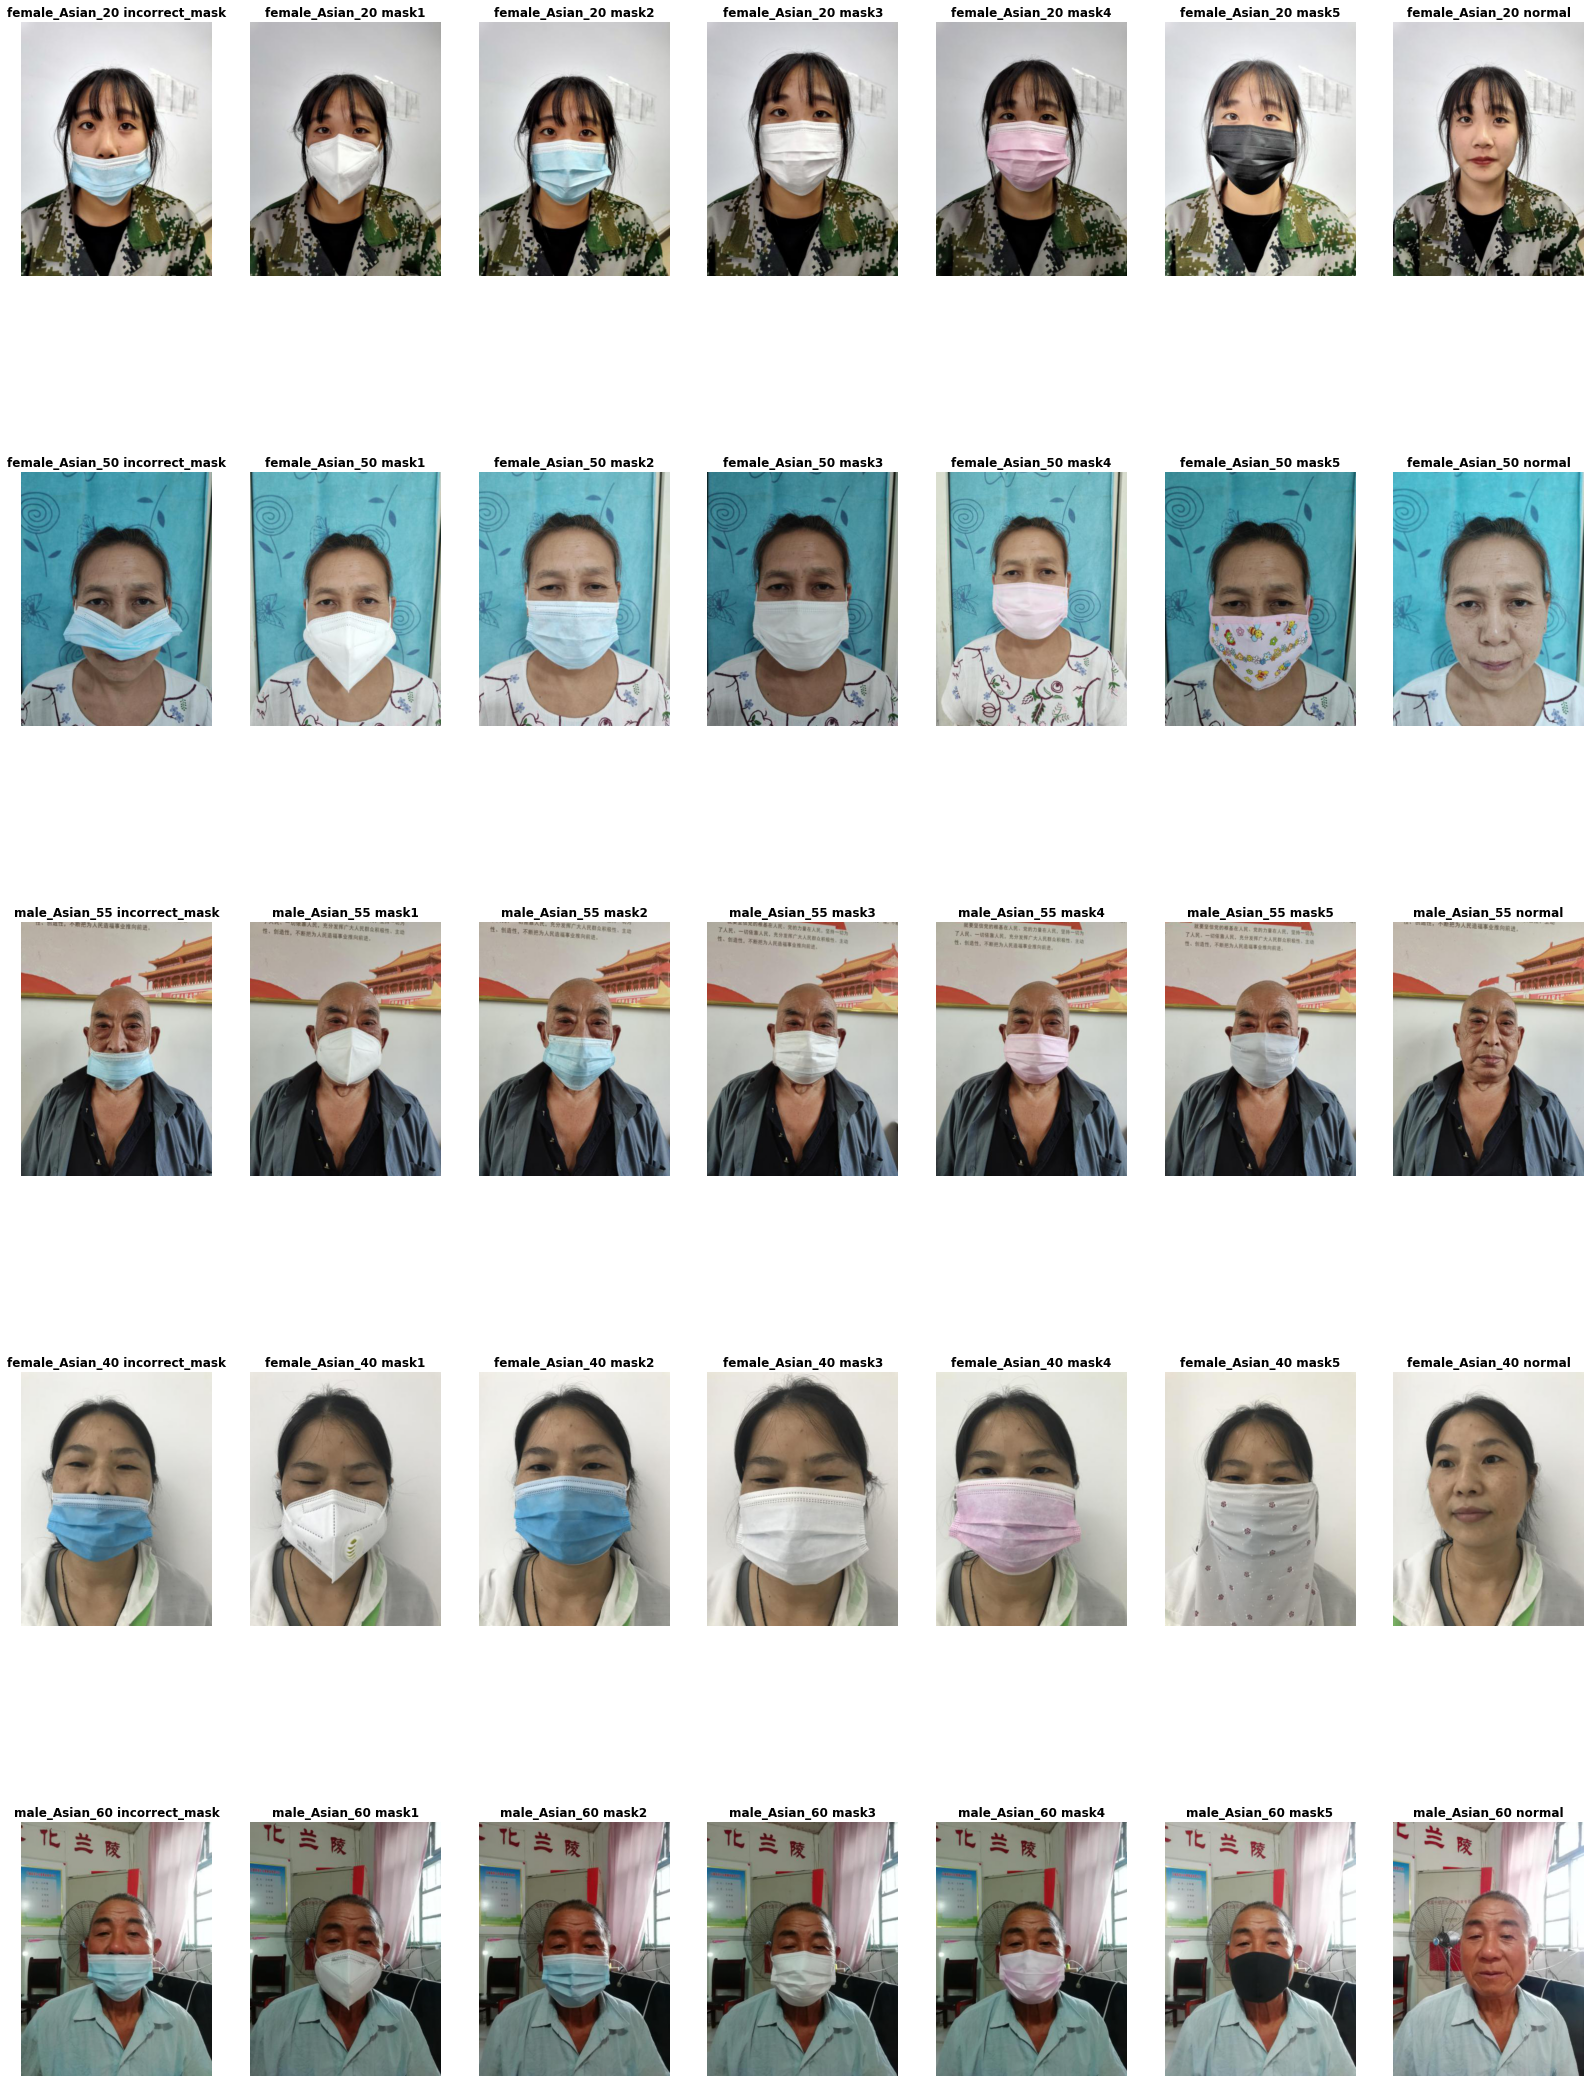

In [6]:
target_number = 5
random_target = random.sample(list(image_paths), target_number)
fig, axes = plt.subplots(target_number, 7, figsize=(28,target_number*8))

for i, target in enumerate(random_target):
    print(i, target)
    images = [image for image in os.listdir(target) if image[0] != '.']
    for j, types in enumerate(sorted(images)) : 
        axes[i][j].imshow(Image.open(os.path.join(target, types)))
        axes[i][j].set_title( target[39:] + ' ' + types[:-4]  , fontweight='bold')
        axes[i][j].axis('off')   

In [7]:
len(train_df)

2700

In [8]:
train_df['race'].value_counts()

Asian    2700
Name: race, dtype: int64

In [9]:
train_df['gender'].value_counts()

female    1658
male      1042
Name: gender, dtype: int64

## 각 사람 7장의 이미지 사이즈

In [10]:
for path in train_df['path'][:1]:
    target = train_image_path + path
    print(target)
    images = [target +'/' + image for image in os.listdir(target) if image[0] != '.']
    for img_path in images:
        train_image = Image.open(img_path)
        print(train_image.size)
        print(np.array(train_image).shape)

/opt/ml/input/data/train/images/000001_female_Asian_45
(384, 512)
(512, 384, 3)
(384, 512)
(512, 384, 3)
(384, 512)
(512, 384, 3)
(384, 512)
(512, 384, 3)
(384, 512)
(512, 384, 3)
(384, 512)
(512, 384, 3)
(384, 512)
(512, 384, 3)


## 모든 이미지 사이즈 모두 동일한지 체크

In [11]:
found = False
for path in tqdm(train_df['path']):
    target = train_image_path + path
    images = [target +'/' + image for image in os.listdir(target) if image[0] != '.']
    for img_path in images:
        train_image = Image.open(img_path)
        if np.array(train_image).shape != (512, 384, 3):
            print('diff')
            found = True
if not found:
    print('all images are same size')

100%|██████████| 2700/2700 [01:01<00:00, 44.13it/s]

all images are same size


## 나이, 성별 클래스별 분포 (Class Description 참고)

In [12]:
train_df['age']

0       45
1       52
2       54
3       58
4       59
        ..
2695    19
2696    19
2697    19
2698    20
2699    19
Name: age, Length: 2700, dtype: int64

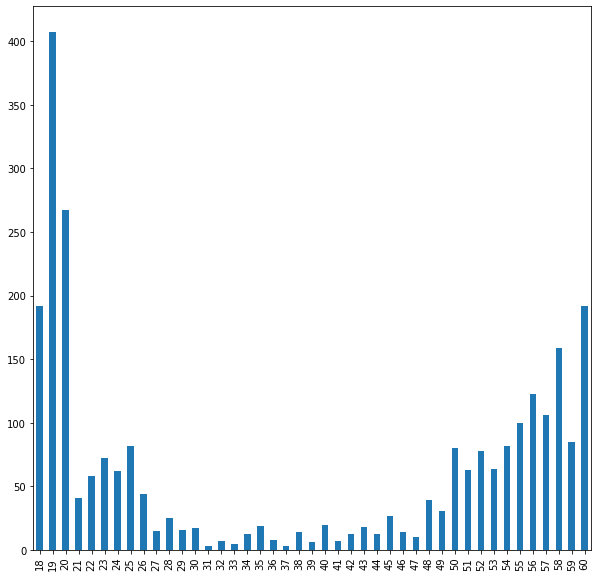

In [13]:
train_df['age'].value_counts().sort_index().plot(kind='bar', figsize=(10,10))

### 나이는 30 미만 young, 30이상 60 미만 mid 60이상 old로 분류

In [14]:
def age_categorize(age):
    if age < 30:
        return 'young'
    elif age >= 30 and age <60:
        return 'mid'
    else:
        return 'old'

In [15]:
train_df['age_cat'] = train_df['age'].apply(age_categorize)

In [16]:
train_df['age_cat'].value_counts()

young    1281
mid      1227
old       192
Name: age_cat, dtype: int64

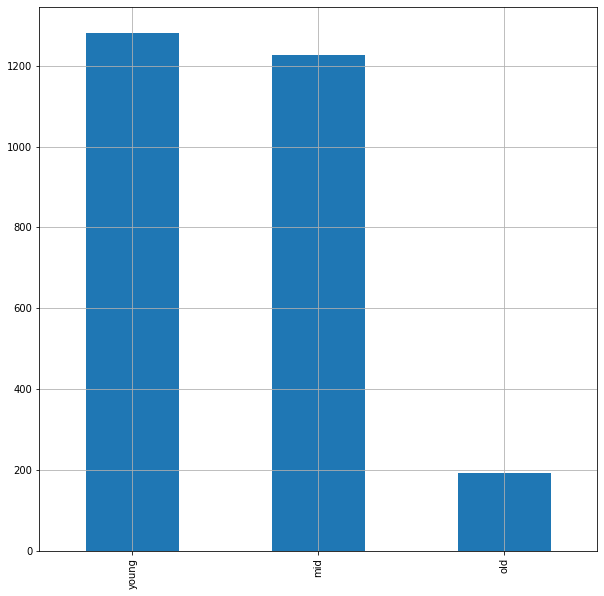

In [17]:
train_df['age_cat'].value_counts().plot(kind='bar', figsize=(10,10), grid=True)

In [18]:
train_df['gender'].value_counts()

female    1658
male      1042
Name: gender, dtype: int64

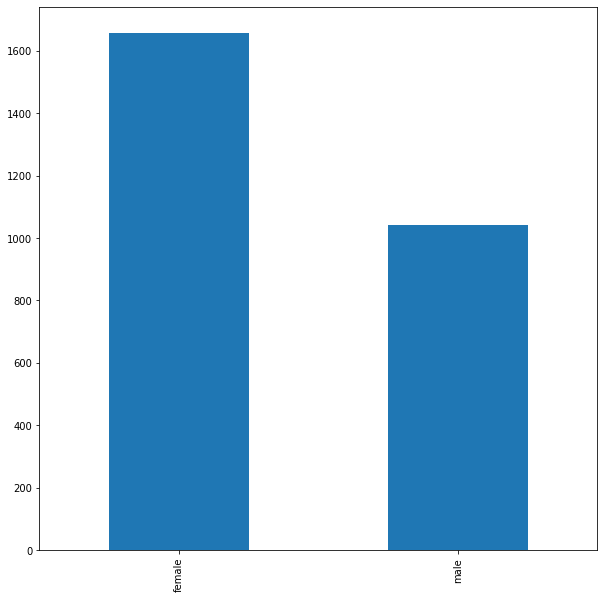

In [19]:
train_df['gender'].value_counts().plot(kind='bar', figsize=(10,10))

In [20]:
train_df['race'].value_counts()

Asian    2700
Name: race, dtype: int64

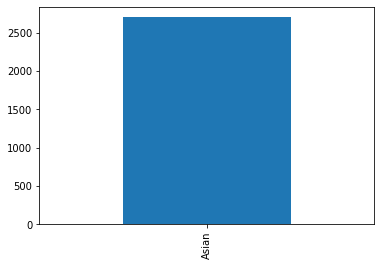

In [21]:
train_df['race'].value_counts().plot(kind='bar')